# ARIMA로 주식 가격 예측

# step1) 시계열 데이터 준비

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Time Series 생성
dataset_filepath = os.getenv('HOME') + '/aiffel/enode14/stock_prediction/data/005930.KS.csv'
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)

- 원본 데이터 변수
    - `Date` : 날짜
    - `Open` : 시작가
    - `High` : 최고가
    - `Low` : 최저가
    - `Close` : 종가
    - `AdjClose` : 수정종가
    - `Volume` : 거래량
- 그 중 종가로만 가격을 분석해보자.

In [3]:
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-05-18,47950.0,49100.0,47600.0,48800.0,46788.835938,20481981
2020-05-19,50100.0,50500.0,49700.0,50300.0,48227.015625,25168295
2020-05-20,50000.0,50200.0,49800.0,50000.0,47939.382813,14896899
2020-05-21,50300.0,50400.0,49850.0,49950.0,47891.437500,14949266
2020-05-22,49600.0,49800.0,48600.0,48750.0,46740.894531,19706284


- 종가만 분리해 Series 형 데이터로 만든다.

In [4]:
ts = df['Close']

ts.head()

Date
2020-05-18    48800.0
2020-05-19    50300.0
2020-05-20    50000.0
2020-05-21    49950.0
2020-05-22    48750.0
Name: Close, dtype: float64

# step2) 결측치 전처리 수행

## 2-1. 결측치 처리
- 장이 열리지 않는 주말을 제외하고는 일정하게 하루에 한 가격씩이 모여 시계열을 이루고 있으므로 단순히 결측치를 제거해버리면 안된다.
- 시간을 기준으로 보간한다.

In [5]:
# 결측치 처리
ts=ts.interpolate(method='time')
ts[ts.isna()]  # Time Series에서 결측치가 있는 부분만 Series로 출력합니다. 

Series([], Name: Close, dtype: float64)

## 2-2. 로그 변환
- 로그 변환을 시도해 원본 데이터와 로그 변환한 데이터 중 어느 쪽이 더 효과가 있는지 확인해보자

In [6]:
# 로그 변환 시도 
ts_log = np.log(ts)

# step3) 시계열 안정성 분석

- 정성적 그래프 분석
- 정량적 Augmented Dicky-Fuller Test
- 시계열 분해(Time Series Decomposition)
- Residual 안정성 확인

## 3-1. 정성적 그래프 분석

### 3-1-1. 일반 시각화
- 원본 데이터 자체는 그렇게 안정적인 데이터가 아니다.
- 시간의 추이에 따라 평균이나 분산이 증가했다가 감소하기도 하는 모습을 보인다.

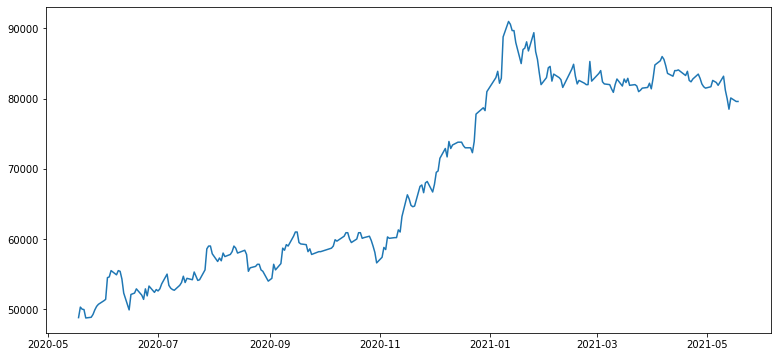

In [7]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 13, 6    # matlab 차트의 기본 크기를 13, 6으로 지정해 줍니다.

plt.plot(ts)

### 3-1-2. Rolling Statistics 시각화

- 원 그래프와 이동평균, 이동표준편차 그래프 확인

In [8]:
def plot_rolling_statistics(timeseries, window=12):
    
    rolmean = timeseries.rolling(window=window).mean()  # 이동평균 시계열
    rolstd = timeseries.rolling(window=window).std()    # 이동표준편차 시계열

     # 원본시계열, 이동평균, 이동표준편차를 plot으로 시각화해 본다.
    orig = plt.plot(timeseries, color='blue',label='Original')    
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

- 아직 이 그래프 만으로는 안정성을 가진다고 확답할 수는 없다.

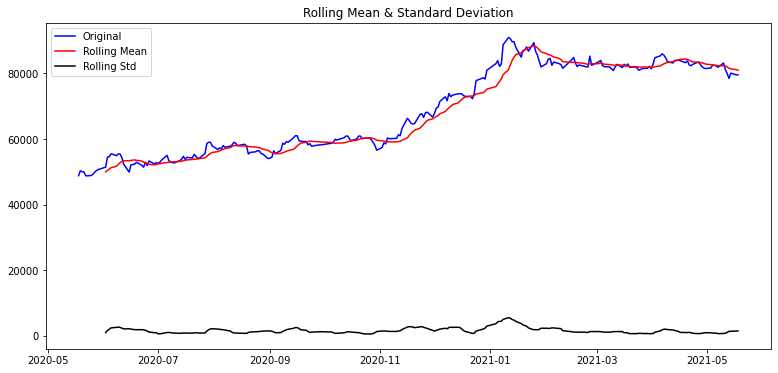

In [9]:
# 정성적 그래프 분석
plot_rolling_statistics(ts, window=12)

- 로그 변환한게 더 나은 걸까...?

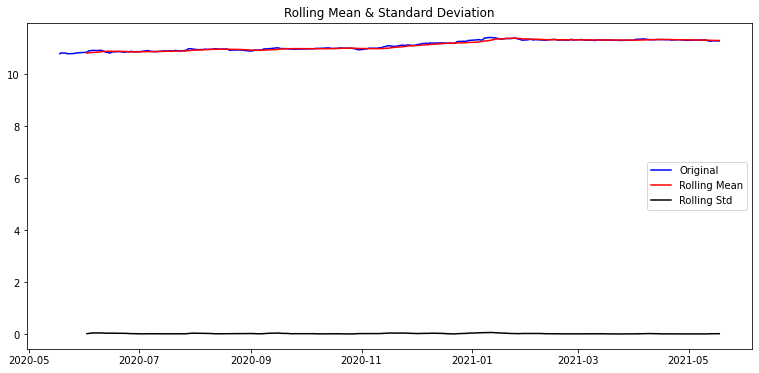

In [10]:
# 정성적 그래프 분석
plot_rolling_statistics(ts_log, window=12)

## 3-2. 정량적 ADF Test
- 귀무가설 : 해당 시계열이 안정적이지 않다.
- 대립가설 : 해당 시계열은 안정적이다.
- 통계적 가설 검정으로 귀무가설이 기각될 경우 대립가설을 채택한다.

In [11]:
from statsmodels.tsa.stattools import adfuller

def augmented_dickey_fuller_test(timeseries):
    # statsmodels 패키지에서 제공하는 adfuller 메소드를 호출합니다.
    dftest = adfuller(timeseries, autolag='AIC')  
    
    # adfuller 메소드가 리턴한 결과를 정리하여 출력합니다.
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

- 로그 변환 전

In [12]:
#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts)

Results of Dickey-Fuller Test:
Test Statistic                  -1.222649
p-value                          0.663778
#Lags Used                       0.000000
Number of Observations Used    249.000000
Critical Value (1%)             -3.456888
Critical Value (5%)             -2.873219
Critical Value (10%)            -2.572994
dtype: float64


- 로그 변환 후
- 확실히 p-value가 작아지긴 했다.
- 귀무가설의 p-value가 0.5로 기각할 만큼 낮게 나오지는 않았다.

In [13]:
#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log)

Results of Dickey-Fuller Test:
Test Statistic                  -1.383525
p-value                          0.590149
#Lags Used                       0.000000
Number of Observations Used    249.000000
Critical Value (1%)             -3.456888
Critical Value (5%)             -2.873219
Critical Value (10%)            -2.572994
dtype: float64


## 3-3. 시계열 분해
- `statsmodels`의 `seasonal_decompose()`를 사용해 추세, 계절성을 제거해보자.

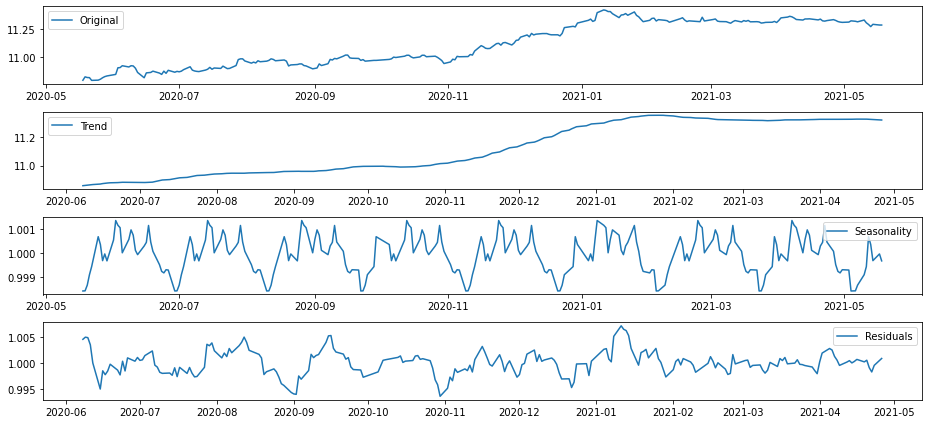

In [14]:
#시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

- p-value가 0.001 이하로 떨어진 모습을 볼 수 있다.

In [15]:
# Residual 안정성 확인
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                -6.187586e+00
p-value                        6.234854e-08
#Lags Used                     9.000000e+00
Number of Observations Used    2.100000e+02
Critical Value (1%)           -3.461879e+00
Critical Value (5%)           -2.875404e+00
Critical Value (10%)          -2.574159e+00
dtype: float64


# step4) train, test 데이터셋 생성

- 전체 데이터 : 2020-05~2021-05
- train_data : 2020-05~2021-04 
- test_data : 2021-04~2021-05

In [16]:
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]

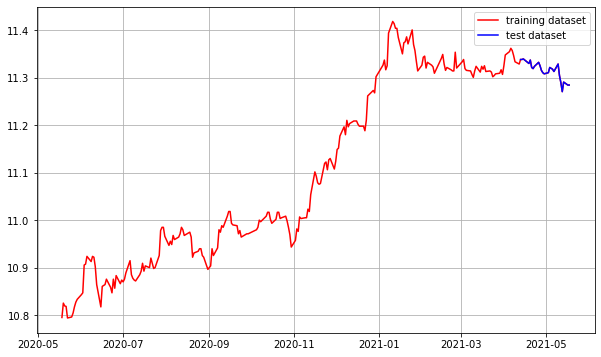

In [17]:
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

# step5) 적정 ARIMA 모수 찾기
## 5-1. ACF, PACF 그려보기
- p,q 구하기

- acf는 감소하는 추세를 보이고 있어 마땅한 q값이 없다.
- pacf는 1 이후에 급격히 0에 가까운 모습을 볼 수 있으니 p=1이 적절한 값이다.

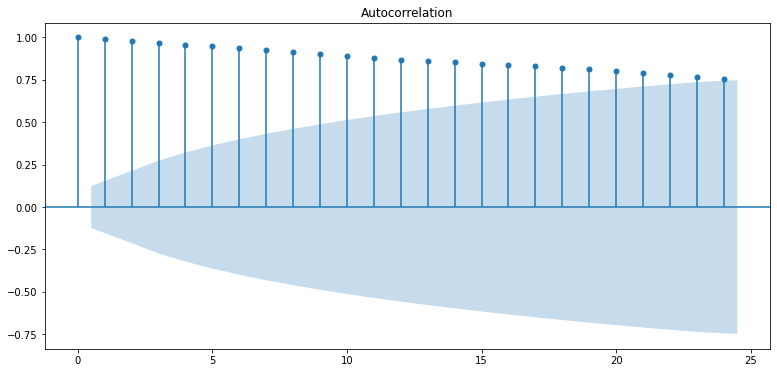

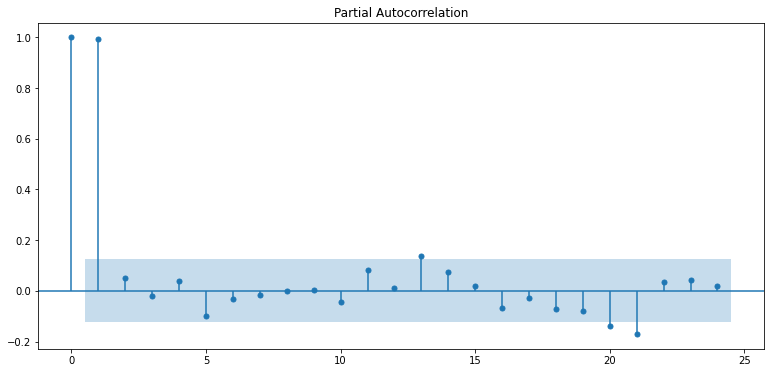

In [18]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

## 5-2. 차분 안정성 확인
- d 구하기

- 오히려 1차 차분했을 때의 p-value가 더 낮은 것을 볼 수 있다.

Results of Dickey-Fuller Test:
Test Statistic                -1.553699e+01
p-value                        2.183738e-28
#Lags Used                     0.000000e+00
Number of Observations Used    2.480000e+02
Critical Value (1%)           -3.456996e+00
Critical Value (5%)           -2.873266e+00
Critical Value (10%)          -2.573019e+00
dtype: float64


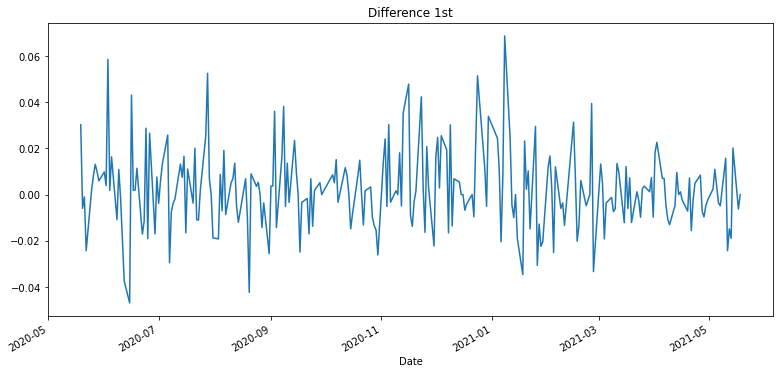

In [19]:
# 1차 차분 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

Results of Dickey-Fuller Test:
Test Statistic                -1.029320e+01
p-value                        3.525823e-18
#Lags Used                     7.000000e+00
Number of Observations Used    2.400000e+02
Critical Value (1%)           -3.457894e+00
Critical Value (5%)           -2.873659e+00
Critical Value (10%)          -2.573229e+00
dtype: float64


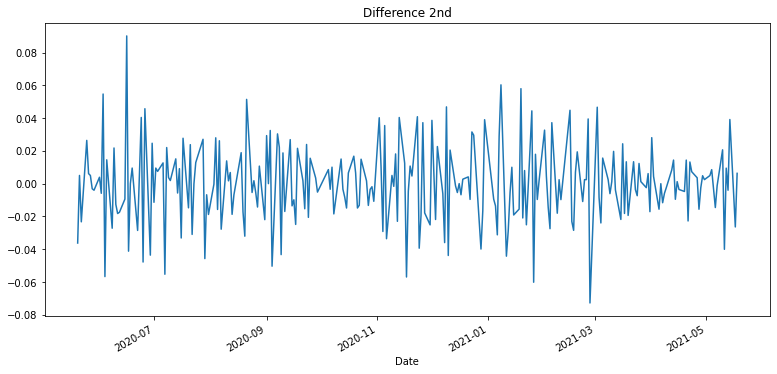

In [20]:
# 혹시 필요한 경우 2차 차분 구하기
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)

# step6) ARIMA 모델 훈련과 테스트

- ARIMA 모델 빌드와 훈련
- 모델 테스트 및 플로팅
- 최종 예측 모델 정확도 측정(MAPE)

## 6-1. 모델 구성

- 앞서 그래프들을 통해 정한 대로 p = 1, q = 0, d = 1로 모델을 돌려 보자.

In [21]:
from statsmodels.tsa.arima_model import ARIMA

# Build Model
model = ARIMA(train_data, order=(1, 1, 0))  
fitted_m = model.fit(disp=-1)  
print(fitted_m.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                  224
Model:                 ARIMA(1, 1, 0)   Log Likelihood                 585.396
Method:                       css-mle   S.D. of innovations              0.018
Date:                Tue, 07 Sep 2021   AIC                          -1164.792
Time:                        14:03:12   BIC                          -1154.557
Sample:                             1   HQIC                         -1160.661
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0024      0.001      1.978      0.048    2.17e-05       0.005
ar.L1.D.Close     0.0168      0.067      0.250      0.803      -0.115       0.148
                                    Root

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


## 6-2. 모델 예측 결과

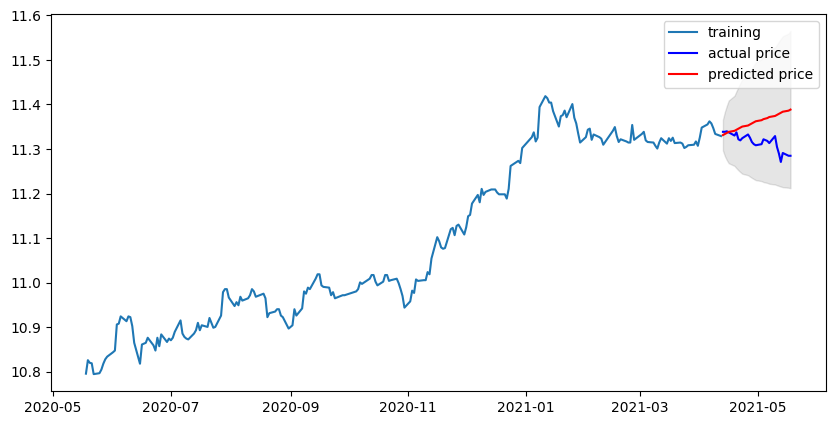

In [22]:
# Forecast : 결과가 fc에 담깁니다. 
fc, se, conf = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과
lower_series = pd.Series(conf[:, 0], index=test_data.index)  # 예측결과의 하한 바운드
upper_series = pd.Series(conf[:, 1], index=test_data.index)  # 예측결과의 상한 바운드

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
plt.legend()
plt.show()

## 6-3. 모델 평가 지표

- MAPE는 4.68%이 나왔다.

In [23]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))


MSE:  22087366.126154922
MAE:  3791.3511527213127
RMSE:  4699.719792301976
MAPE: 4.68%


- MAPE가 1.5%로 꽤 만족스러운 지표를 보여주고 있다.

# step7) 다른 주식 종목 예측해 보기

- 다른 주식 종목도 예측해보자.
- def `predict_price(filename, stockname)` : 주가 csv 파일 기반으로 안정적인지 정성적, 정량적 테스트를 진행하고 train, test 데이터를 분리해 반환한다.

In [24]:
def predict_price(filename, stockname):
    print(f'============={stockname}==================')
    dataset_filepath = os.getenv('HOME') + f'/aiffel/enode14/stock_prediction/data/{filename}'
    df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
    ts = df['Close']
    plt.plot(ts)
    plt.title("Original Data")
    plt.show()

    # 결측치 처리
    if ts.isna().sum():
        ts=ts.interpolate(method='time')
        plt.plot(ts)
        plt.title("After Interpolate")
        plt.show()
    
    # 로그 변환
    ts_log = np.log(ts)
    plt.plot(ts_log)
    plt.title("After Log")
    plt.show()

    # 정성적 그래프 분석
    print(f'{stockname} 종목 정성적 그래프 분석')
    plot_rolling_statistics(ts_log, window=12)

    #정량적 Augmented Dicky-Fuller Test
    print(f'{stockname} 종목 정량적 ADF Test 분석')
    augmented_dickey_fuller_test(ts_log)

    # 시계열 분해
    decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 
    trend = decomposition.trend
    seasonal = decomposition.seasonal
    residual = decomposition.resid
    
    print(f'{stockname} 종목 시계열 분해')
    plt.subplot(411)
    plt.plot(ts_log, label='Original')
    plt.legend(loc='best')
    plt.subplot(412)
    plt.plot(trend, label='Trend')
    plt.legend(loc='best')
    plt.subplot(413)
    plt.plot(seasonal,label='Seasonality')
    plt.legend(loc='best')
    plt.subplot(414)
    plt.plot(residual, label='Residuals')
    plt.legend(loc='best')
    plt.tight_layout()

    # Residual 안정성 확인
    residual.dropna(inplace=True)
    augmented_dickey_fuller_test(residual)

    train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]

    plt.figure(figsize=(10,6))
    plt.grid(True)
    plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
    plt.plot(test_data, c='b', label='test dataset')
    plt.legend()

    plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
    plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
    plt.show()

    # 차분 안정성 확인
    print(f'{stockname} 차분 안정성 확인')
    
    print('====1차 차분====')
    # 1차 차분 구하기
    diff_1 = ts_log.diff(periods=1).iloc[1:]
    diff_1.plot(title='Difference 1st')
    plt.show()
    augmented_dickey_fuller_test(diff_1)
    
    print('====2차 차분====')
    # 2차 차분 구하기
    diff_2 = diff_1.diff(periods=1).iloc[1:]
    diff_2.plot(title='Difference 2nd')
    plt.show()
    augmented_dickey_fuller_test(diff_2)
    return train_data, test_data

In [25]:
def build_and_train(p, q, d, train_data, test_data):
    # 모델 생성
    # Build Model
    model = ARIMA(train_data, order=(p, d, q))  
    fitted_m = model.fit(disp=-1)  
    print(fitted_m.summary())
    
    # Forecast : 결과가 fc에 담깁니다. 
    fc, se, conf = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf

    # Make as pandas series
    fc_series = pd.Series(fc, index=test_data.index)   # 예측결과
    lower_series = pd.Series(conf[:, 0], index=test_data.index)  # 예측결과의 하한 바운드
    upper_series = pd.Series(conf[:, 1], index=test_data.index)  # 예측결과의 상한 바운드

    # Plot
    plt.figure(figsize=(10,5), dpi=100)
    plt.plot(train_data, label='training')
    plt.plot(test_data, c='b', label='actual price')
    plt.plot(fc_series, c='r',label='predicted price')
    plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
    plt.legend()
    plt.show()

    # 모델 지표
    mse = mean_squared_error(np.exp(test_data), np.exp(fc))
    print('MSE: ', mse)

    mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
    print('MAE: ', mae)

    rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
    print('RMSE: ', rmse)

    mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
    print('MAPE: {:.2f}%'.format(mape*100))

## 7-1. 카카오 예측

=============카카오==================


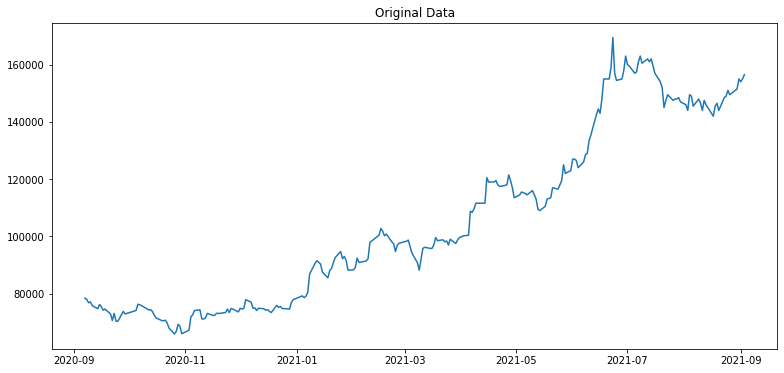

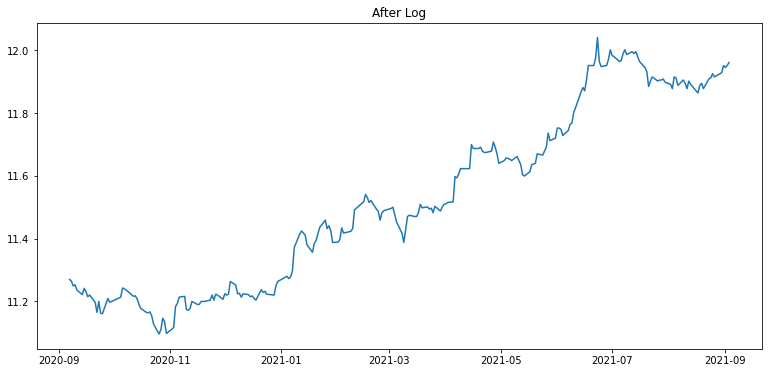

카카오 종목 정성적 그래프 분석


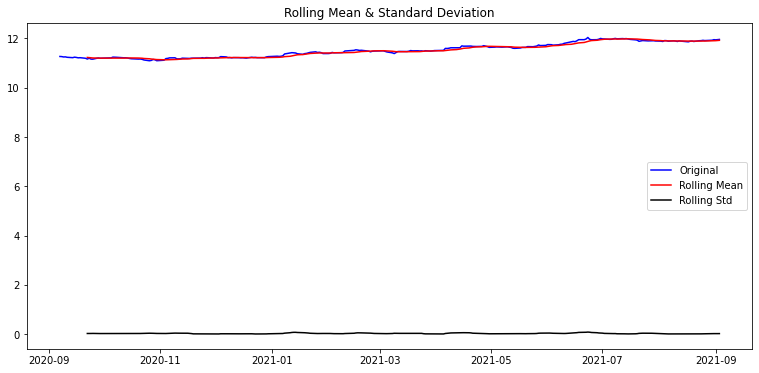

카카오 종목 정량적 ADF Test 분석
Results of Dickey-Fuller Test:
Test Statistic                   0.007583
p-value                          0.959155
#Lags Used                       0.000000
Number of Observations Used    246.000000
Critical Value (1%)             -3.457215
Critical Value (5%)             -2.873362
Critical Value (10%)            -2.573070
dtype: float64
카카오 종목 시계열 분해
Results of Dickey-Fuller Test:
Test Statistic                  -5.243341
p-value                          0.000007
#Lags Used                       1.000000
Number of Observations Used    215.000000
Critical Value (1%)             -3.461136
Critical Value (5%)             -2.875079
Critical Value (10%)            -2.573986
dtype: float64


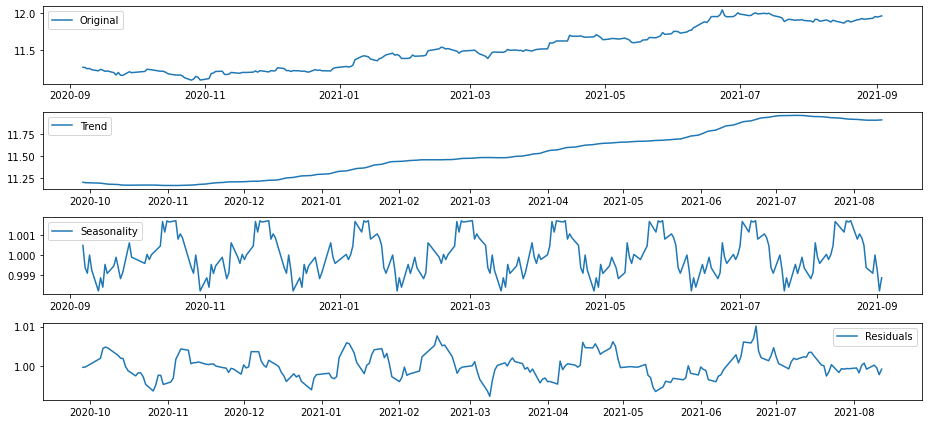

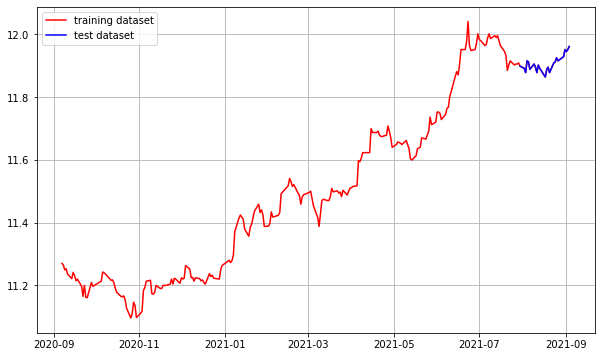

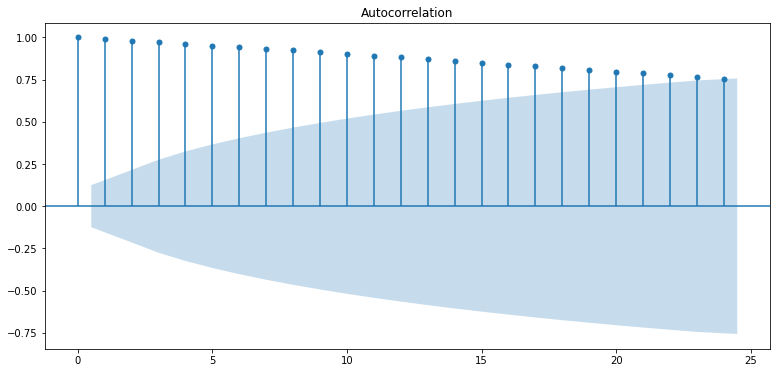

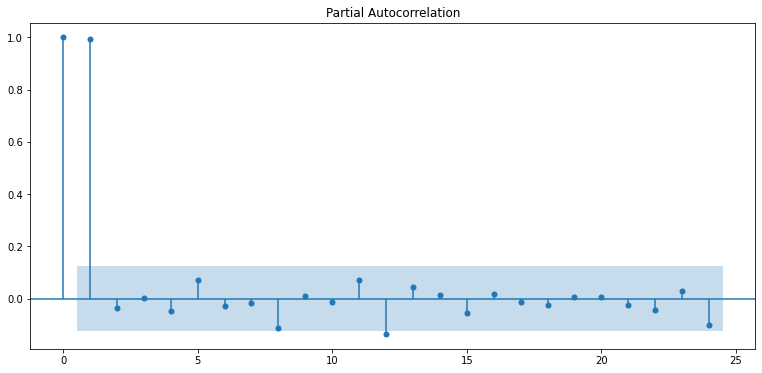

카카오 차분 안정성 확인
====1차 차분====


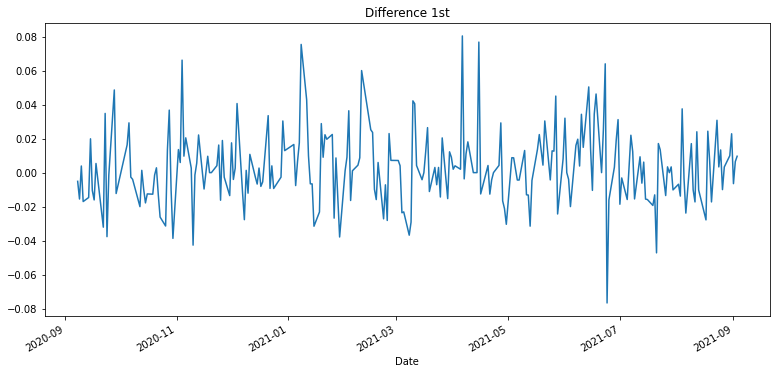

Results of Dickey-Fuller Test:
Test Statistic                -1.468894e+01
p-value                        3.071268e-27
#Lags Used                     0.000000e+00
Number of Observations Used    2.450000e+02
Critical Value (1%)           -3.457326e+00
Critical Value (5%)           -2.873410e+00
Critical Value (10%)          -2.573096e+00
dtype: float64
====2차 차분====


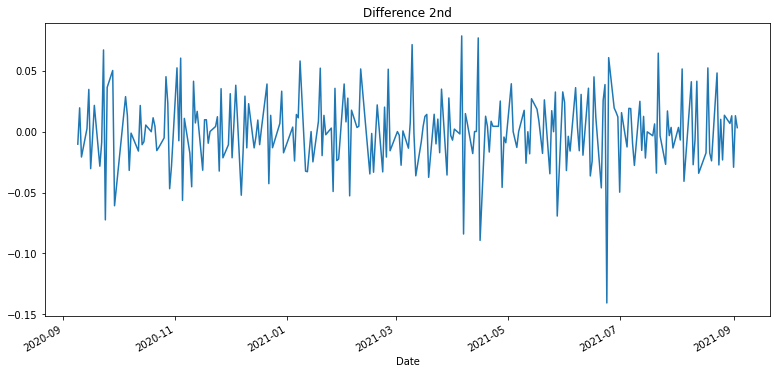

Results of Dickey-Fuller Test:
Test Statistic                -8.293183e+00
p-value                        4.207723e-13
#Lags Used                     9.000000e+00
Number of Observations Used    2.350000e+02
Critical Value (1%)           -3.458487e+00
Critical Value (5%)           -2.873919e+00
Critical Value (10%)          -2.573367e+00
dtype: float64


In [26]:
ka_train, ka_test = predict_price('035720.KS.csv','카카오')

- 카카오의 경우 ACF는 점차 감소하는 모습을 보여 q = 0이 적절할 것 같다.
- PACF는 1 이후로 0에 가까운 모습을 보이고 있다. p = 1이 적절할 것 같다.
- 차분 전에도 시계열 분해 만으로 p-value가 0.000007 였다.
- 2차 차분 시 p-value가 더 증가했으므로 d = 1과 d = 0 둘 다 진행해보자.

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                  221
Model:                 ARIMA(1, 1, 0)   Log Likelihood                 527.299
Method:                       css-mle   S.D. of innovations              0.022
Date:                Tue, 07 Sep 2021   AIC                          -1048.598
Time:                        14:03:15   BIC                          -1038.403
Sample:                             1   HQIC                         -1044.481
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0029      0.002      1.767      0.077      -0.000       0.006
ar.L1.D.Close     0.0842      0.067      1.258      0.208      -0.047       0.215
                                    Root

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


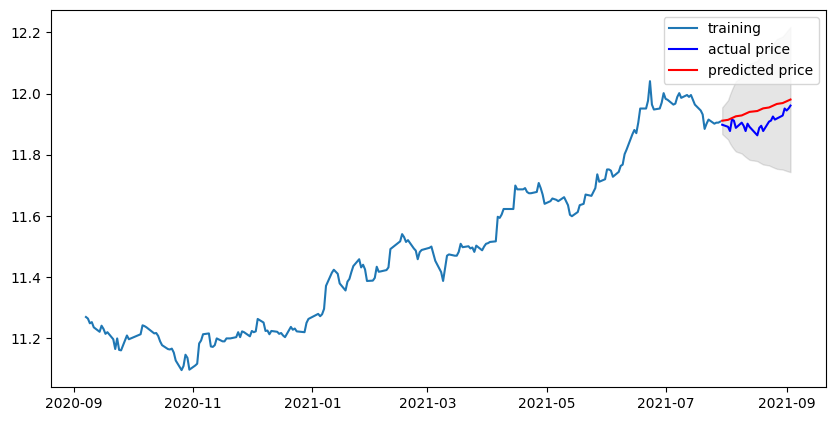

MSE:  40640627.392147645
MAE:  5779.921836155599
RMSE:  6375.00018761942
MAPE: 3.92%


In [27]:
build_and_train(1,0,1,ka_train, ka_test)

- 역시 차분을 하지 않았을 때 조금 더 낮은 MAPE를 얻을 수 있었다.

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                              ARMA Model Results                              
Dep. Variable:                  Close   No. Observations:                  222
Model:                     ARMA(1, 0)   Log Likelihood                 524.568
Method:                       css-mle   S.D. of innovations              0.023
Date:                Tue, 07 Sep 2021   AIC                          -1043.137
Time:                        14:03:16   BIC                          -1032.929
Sample:                             0   HQIC                         -1039.015
                                                                              
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const          11.5652      0.269     43.050      0.000      11.039      12.092
ar.L1.Close     0.9973      0.003    316.035      0.000       0.991       1.003
                                    Roots       

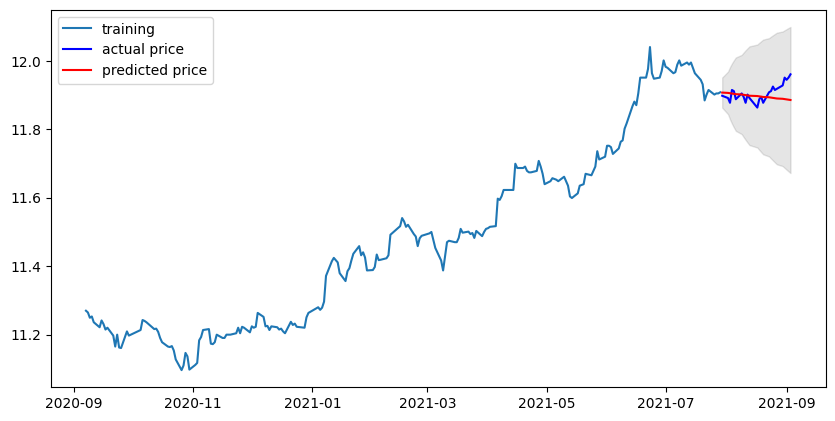

MSE:  22436502.54670845
MAE:  3586.8861389579133
RMSE:  4736.718542061419
MAPE: 2.38%


In [28]:
build_and_train(1,0,0,ka_train, ka_test)

## 7-2. SK 텔레콤

=============SK텔레콤==================


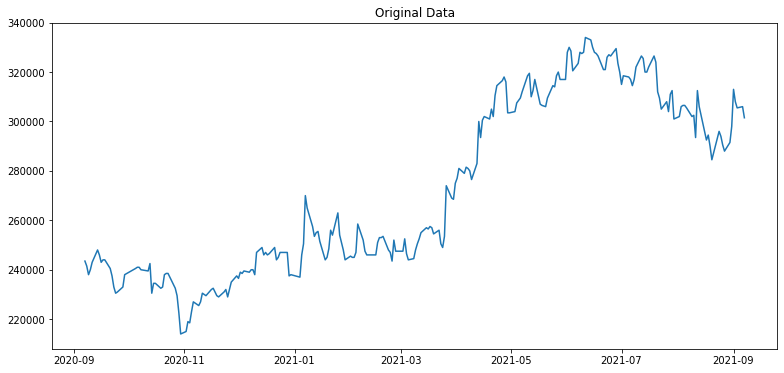

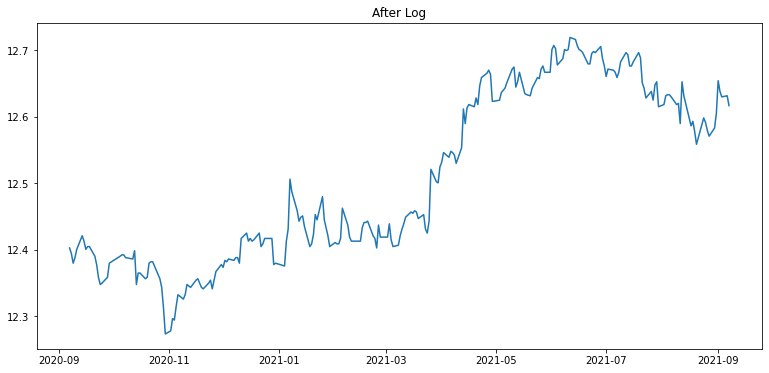

SK텔레콤 종목 정성적 그래프 분석


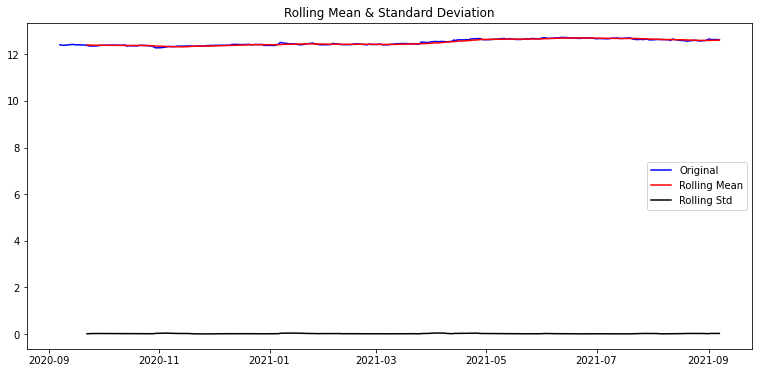

SK텔레콤 종목 정량적 ADF Test 분석
Results of Dickey-Fuller Test:
Test Statistic                  -1.087112
p-value                          0.720184
#Lags Used                       0.000000
Number of Observations Used    248.000000
Critical Value (1%)             -3.456996
Critical Value (5%)             -2.873266
Critical Value (10%)            -2.573019
dtype: float64
SK텔레콤 종목 시계열 분해
Results of Dickey-Fuller Test:
Test Statistic                -6.878209e+00
p-value                        1.456057e-09
#Lags Used                     1.000000e+00
Number of Observations Used    2.170000e+02
Critical Value (1%)           -3.460849e+00
Critical Value (5%)           -2.874953e+00
Critical Value (10%)          -2.573919e+00
dtype: float64


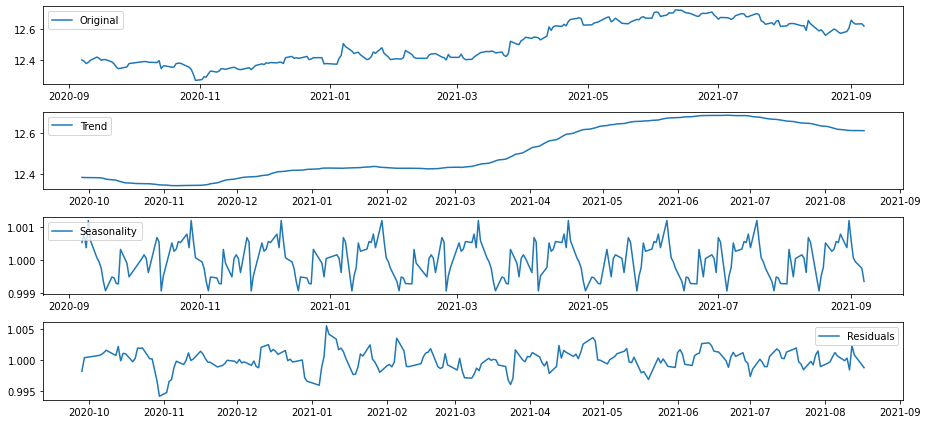

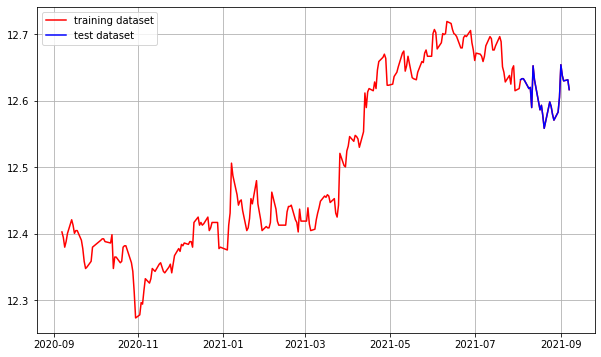

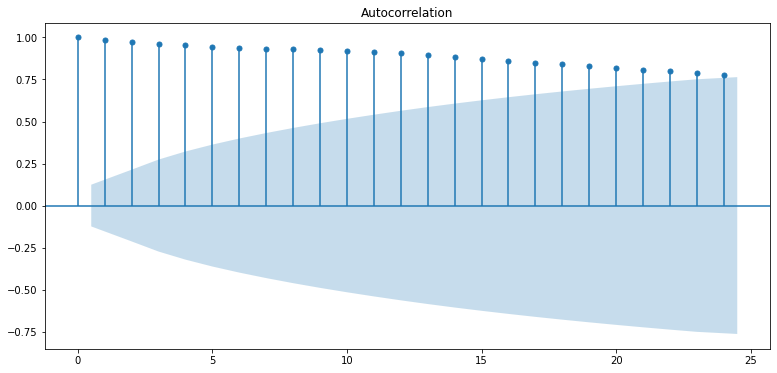

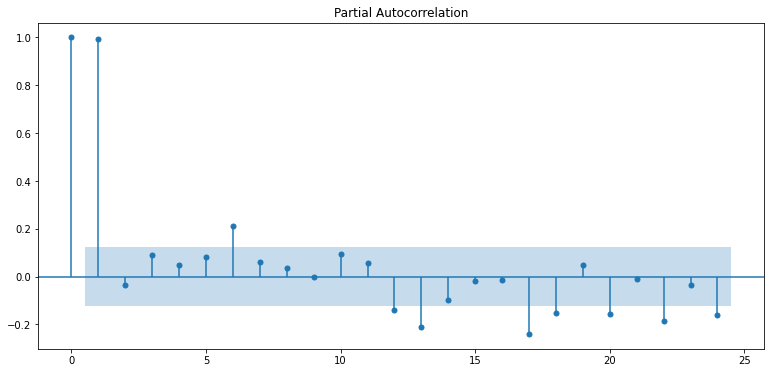

SK텔레콤 차분 안정성 확인
====1차 차분====


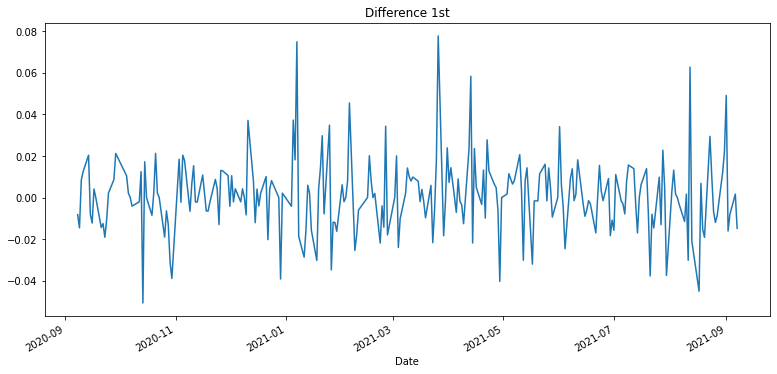

Results of Dickey-Fuller Test:
Test Statistic                -1.233004e+01
p-value                        6.457617e-23
#Lags Used                     1.000000e+00
Number of Observations Used    2.460000e+02
Critical Value (1%)           -3.457215e+00
Critical Value (5%)           -2.873362e+00
Critical Value (10%)          -2.573070e+00
dtype: float64
====2차 차분====


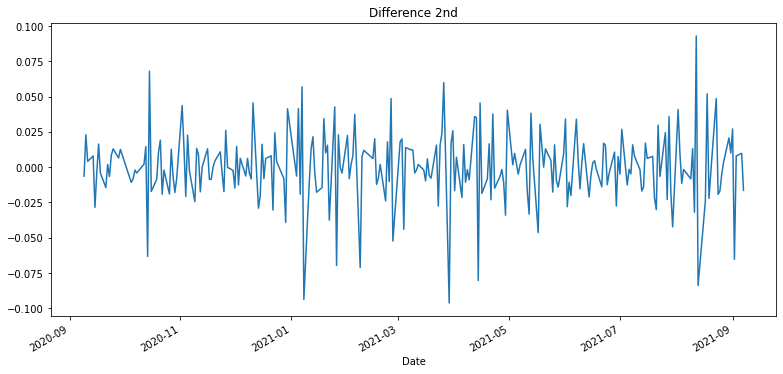

Results of Dickey-Fuller Test:
Test Statistic                -7.912294e+00
p-value                        3.918660e-12
#Lags Used                     1.400000e+01
Number of Observations Used    2.320000e+02
Critical Value (1%)           -3.458855e+00
Critical Value (5%)           -2.874080e+00
Critical Value (10%)          -2.573453e+00
dtype: float64


In [29]:
skt_train, skt_test = predict_price('017670.KS.csv', 'SK텔레콤')

- SK 텔레콤 역시 ACF는 점차 감소하는 모습을 보여 q = 0이 적절해 보인다.
- PACF도 1 이후로 0에 가까운 모습을 보이고 있다. p = 1이 적절할 것 같다.
- 차분 전에도 시계열 분해 만으로 p-value가 1.456057e-09로 충분히 낮았다.
- 차분 없이 진행해보자.

                              ARMA Model Results                              
Dep. Variable:                  Close   No. Observations:                  224
Model:                     ARMA(2, 0)   Log Likelihood                 590.221
Method:                       css-mle   S.D. of innovations              0.017
Date:                Tue, 07 Sep 2021   AIC                          -1172.442
Time:                        14:03:18   BIC                          -1158.795
Sample:                             0   HQIC                         -1166.934
                                                                              
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const          12.5037      0.085    147.054      0.000      12.337      12.670
ar.L1.Close     1.0159      0.067     15.250      0.000       0.885       1.147
ar.L2.Close    -0.0258      0.067     -0.387    

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


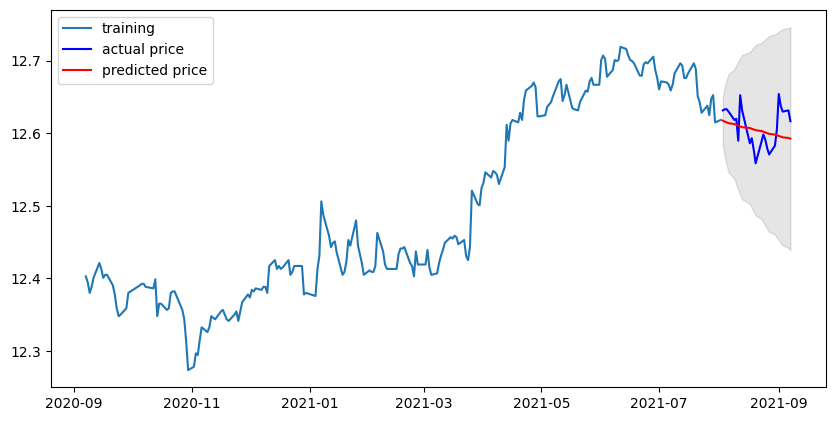

MSE:  63633367.429525845
MAE:  6838.632222536516
RMSE:  7977.052552761944
MAPE: 2.27%


In [30]:
build_and_train(2,0,0,skt_train, skt_test)

- MAPE 2.27%의 결과를 얻을 수 있었다.

## 7-3. Google 예측

=============Google==================


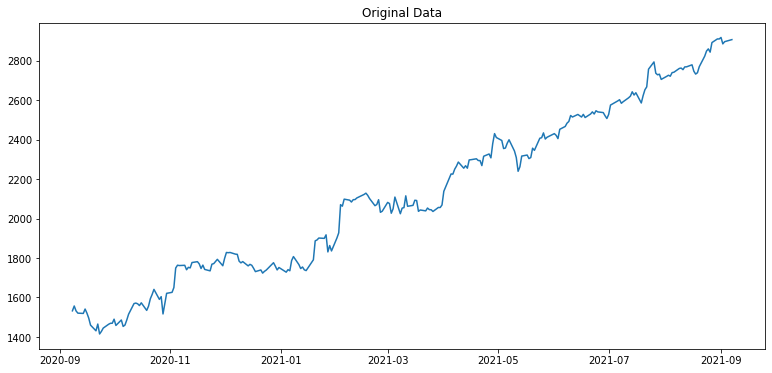

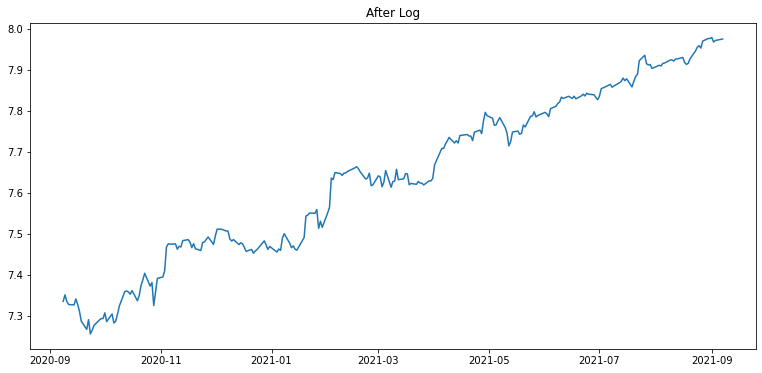

Google 종목 정성적 그래프 분석


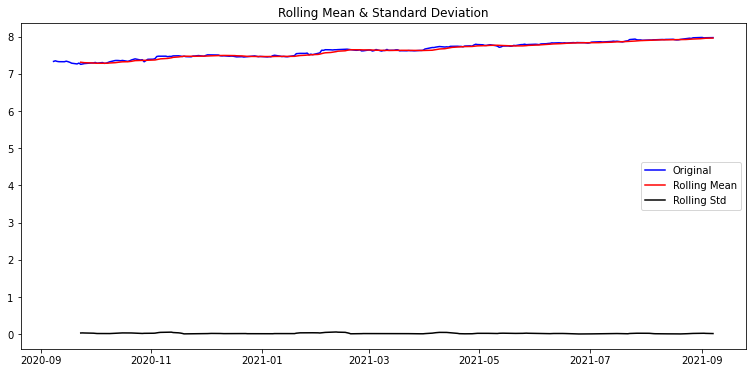

Google 종목 정량적 ADF Test 분석
Results of Dickey-Fuller Test:
Test Statistic                  -0.421499
p-value                          0.906447
#Lags Used                       7.000000
Number of Observations Used    244.000000
Critical Value (1%)             -3.457438
Critical Value (5%)             -2.873459
Critical Value (10%)            -2.573122
dtype: float64
Google 종목 시계열 분해
Results of Dickey-Fuller Test:
Test Statistic                  -2.758381
p-value                          0.064469
#Lags Used                      15.000000
Number of Observations Used    206.000000
Critical Value (1%)             -3.462499
Critical Value (5%)             -2.875675
Critical Value (10%)            -2.574304
dtype: float64


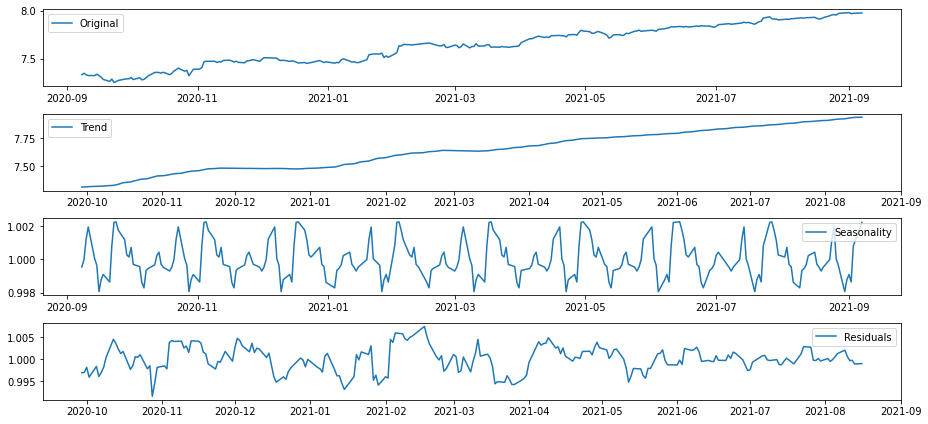

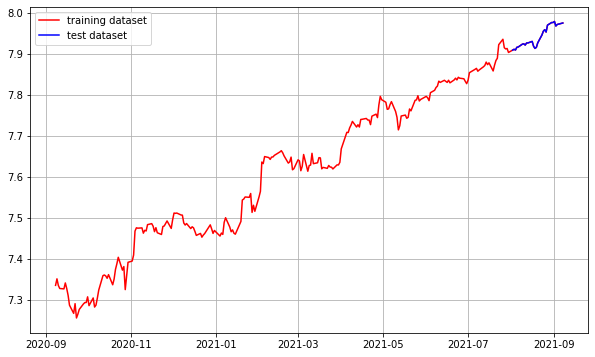

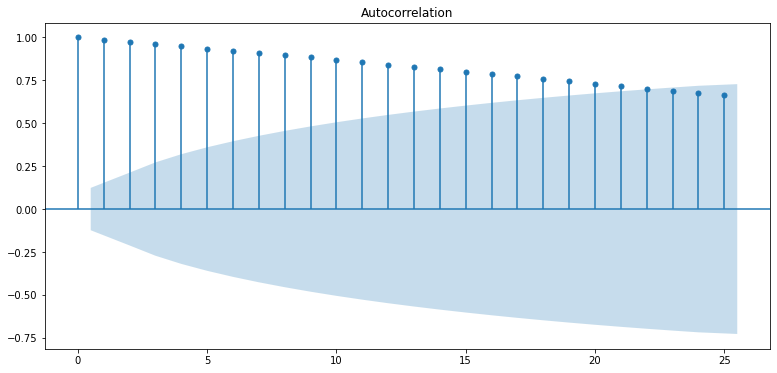

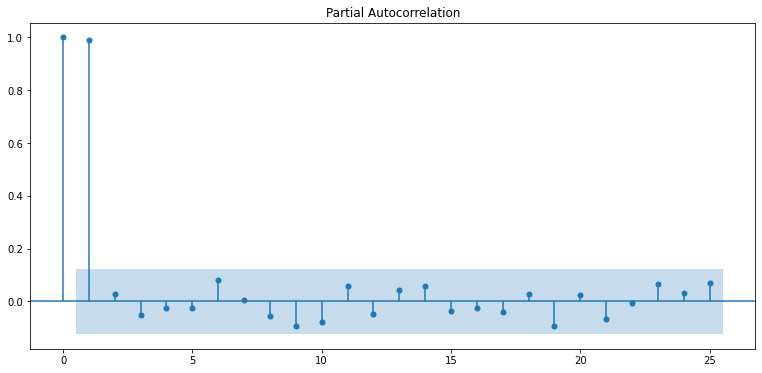

Google 차분 안정성 확인
====1차 차분====


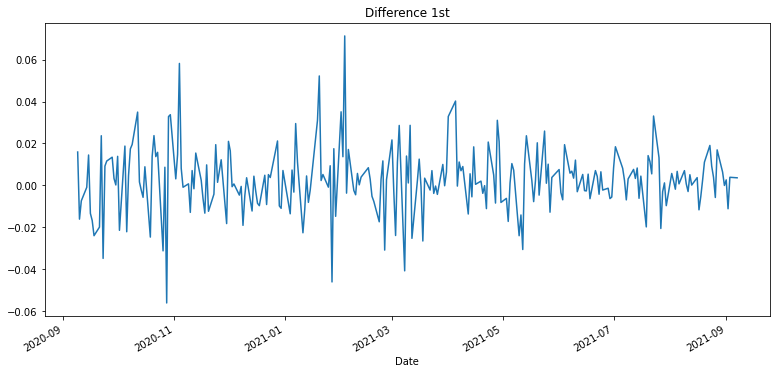

Results of Dickey-Fuller Test:
Test Statistic                -6.603477e+00
p-value                        6.645672e-09
#Lags Used                     6.000000e+00
Number of Observations Used    2.440000e+02
Critical Value (1%)           -3.457438e+00
Critical Value (5%)           -2.873459e+00
Critical Value (10%)          -2.573122e+00
dtype: float64
====2차 차분====


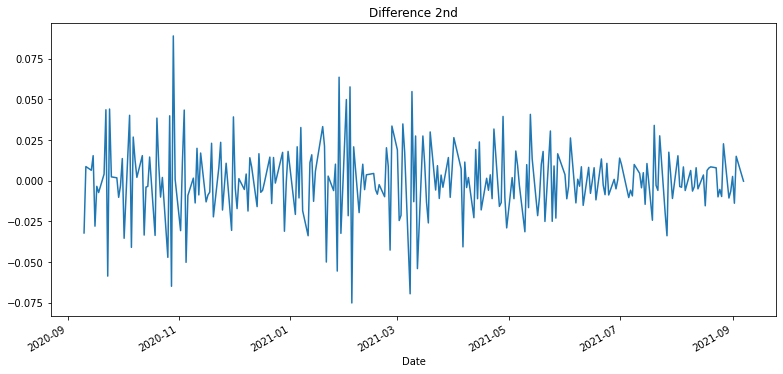

Results of Dickey-Fuller Test:
Test Statistic                -6.946534e+00
p-value                        9.939070e-10
#Lags Used                     1.600000e+01
Number of Observations Used    2.330000e+02
Critical Value (1%)           -3.458731e+00
Critical Value (5%)           -2.874026e+00
Critical Value (10%)          -2.573424e+00
dtype: float64


In [31]:
goo_train, goo_test = predict_price('GOOG.csv', 'Google')

                             ARIMA Model Results                              
Dep. Variable:               D2.Close   No. Observations:                  224
Model:                 ARIMA(1, 2, 0)   Log Likelihood                 560.017
Method:                       css-mle   S.D. of innovations              0.020
Date:                Tue, 07 Sep 2021   AIC                          -1114.035
Time:                        14:03:21   BIC                          -1103.800
Sample:                             2   HQIC                         -1109.903
                                                                              
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const          -4.683e-05      0.001     -0.055      0.957      -0.002       0.002
ar.L1.D2.Close    -0.5459      0.056     -9.748      0.000      -0.656      -0.436
                                    

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


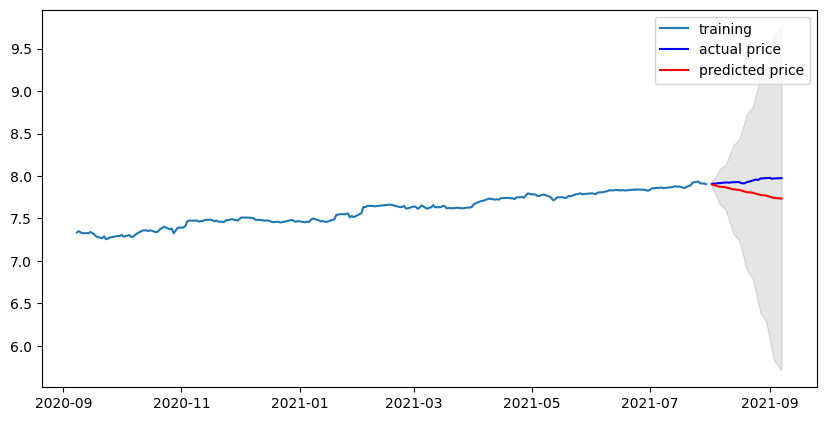

MSE:  134188.18682799002
MAE:  314.46002990526506
RMSE:  366.3170577900926
MAPE: 11.06%


In [32]:
build_and_train(1,0,2, goo_train, goo_test)

- 왜.. ACF가 감소해도 p=1, q=1인 경우가 더 MAPE 지표가 좋게 나올까?

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:               D2.Close   No. Observations:                  224
Model:                 ARIMA(1, 2, 1)   Log Likelihood                 600.369
Method:                       css-mle   S.D. of innovations              0.016
Date:                Tue, 07 Sep 2021   AIC                          -1192.737
Time:                        14:03:21   BIC                          -1179.091
Sample:                             2   HQIC                         -1187.229
                                                                              
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const            4.15e-06   1.62e-05      0.257      0.797   -2.75e-05    3.58e-05
ar.L1.D2.Close    -0.0415      0.067     -0.620      0.535      -0.173       0.090
ma.L1.D2.Close    -0.9999      0.012

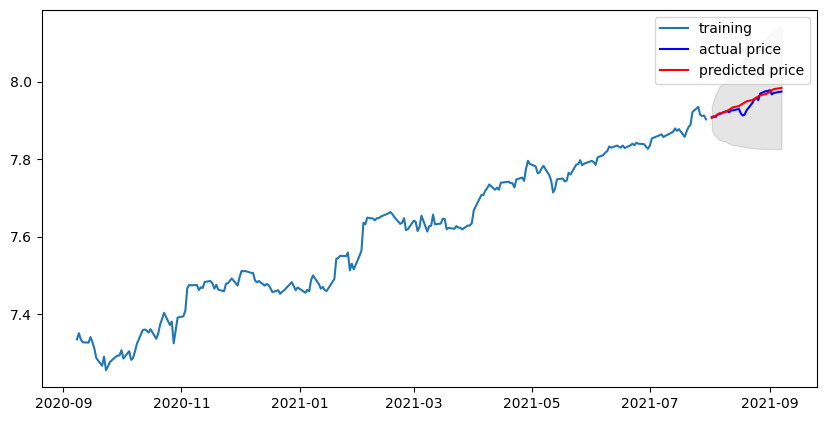

MSE:  1108.0287967393392
MAE:  23.134037674626825
RMSE:  33.28706650847051
MAPE: 0.83%


In [33]:
build_and_train(1,1,2, goo_train, goo_test)

# 회고
- 통계와 거리가 멀어서 생소한 개념들이 많았는데 이번 기회에 공부할 수 있었다.
- 첫번째 종목으로 모델을 구성할 때 p,q,d 파라미터 순서를 헷갈려서 그래프들을 통해 얻은 값은 p = 1, q = 0, d = 1, 이었는데 p = 1, q = 1, d = 0로 잘못 넣었었다. 그런데 그 경우가 MAPE가 1.56%로 더 낮게 나왔다.
- 전반적으로 ACF 그래프가 감소해도 p=1, q=1로 모델링 하는 게 MAPE가 더 낮았다.
- 조금 더 공부가 필요해 보인다.

## 참고 자료
[ARIMA](https://leedakyeong.tistory.com/entry/ARIMA%EB%9E%80-ARIMA-%EB%B6%84%EC%84%9D%EA%B8%B0%EB%B2%95-AR-MA-ACF-PACF-%EC%A0%95%EC%83%81%EC%84%B1%EC%9D%B4%EB%9E%80)